In [2]:
import os, sys

sys.path.append(os.path.abspath(os.path.join("../..")))
from utils import *

In [3]:
from scipy.stats import t, laplace, norm
import seaborn as sns
from sklearn.datasets import make_spd_matrix

In [4]:
import matplotlib.pyplot as plt
import numpy as np


def hinton(matrix, max_weight=None, ax=None):
    ax = ax if ax is not None else plt.gca()

    if not max_weight:
        max_weight = 2 ** np.ceil(np.log2(np.abs(matrix).max()))

    ax.set_aspect("equal", "box")
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

    for (x, y), w in np.ndenumerate(matrix):
        color = COLOR_LIST[0] if w > 0 else COLOR_LIST[1]
        size = np.sqrt(abs(w) / max_weight)
        rect = plt.Rectangle(
            [x - size / 2, y - size / 2], size, size, facecolor=color, edgecolor=color
        )
        ax.add_patch(rect)

    ax.autoscale_view()
    ax.invert_yaxis()

In [5]:
def gauss_condition(mu, sigma, visible_nodes, visible_values):
    dim = len(mu)

    # Indices of hidden nodes
    hidden_nodes = [i for i in range(dim) if i not in visible_nodes]

    # Partition the covariance matrix
    sigma_visible = sigma[visible_nodes][:, visible_nodes]
    sigma_hidden = sigma[hidden_nodes][:, hidden_nodes]
    sigma_cross = sigma[hidden_nodes][:, visible_nodes]

    # Compute conditional mean and covariance matrix
    mu_hidden = mu[hidden_nodes] + sigma_cross @ np.linalg.inv(sigma_visible) @ (
        visible_values - mu[visible_nodes]
    )
    sigma_hidden_given_visible = (
        sigma_hidden - sigma_cross @ np.linalg.inv(sigma_visible) @ sigma_cross.T
    )

    return mu_hidden, sigma_hidden_given_visible


def gauss_impute(mu, sigma, x):
    n_data, data_dim = x.shape
    x_imputed = np.copy(x)
    for i in range(n_data):
        hidden_nodes = np.argwhere(np.isnan(x[i, :]))
        visible_nodes = np.argwhere(~np.isnan(x[i, :])).reshape(-1)
        visible_values = np.zeros(len(visible_nodes))
        for tc, h in enumerate(visible_nodes):
            visible_values[tc] = x[i, h]
        mu_hgv, sigma_hgv = gauss_condition(mu, sigma, visible_nodes, visible_values)
        for rr, h in enumerate(hidden_nodes):
            x_imputed[i, h] = mu_hgv[rr]
    return x_imputed

In [6]:
def gen_imputer_data(data_dim=8, sample_size=10, threshold_missing=0.5, plot=True):
    mean = np.random.normal(size=data_dim)
    cov = make_spd_matrix(data_dim)

    gt_data = np.random.multivariate_normal(mean, cov, size=sample_size)
    mask = np.random.binomial(1, threshold_missing, size=gt_data.shape)

    data = gt_data.copy()
    data[mask == 1] = np.nan

    # imputing missing data with multivariate normal
    imputed_data = gauss_impute(mean, cov, data)

    if plot:
        # plot in grid 1x3
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        # plot ground truth
        hinton(gt_data, ax=axes[0])
        axes[0].set_title("Ground Truth Covariance")

        # plot data with missing values
        data_ = data.copy()
        data_[np.isnan(data_)] = 0
        hinton(data_, ax=axes[1])
        axes[1].set_title("Data with Missing Values")

        # plot imputed data
        hinton(imputed_data, ax=axes[2])
        axes[2].set_title("Imputed Data")

    return gt_data, data, imputed_data

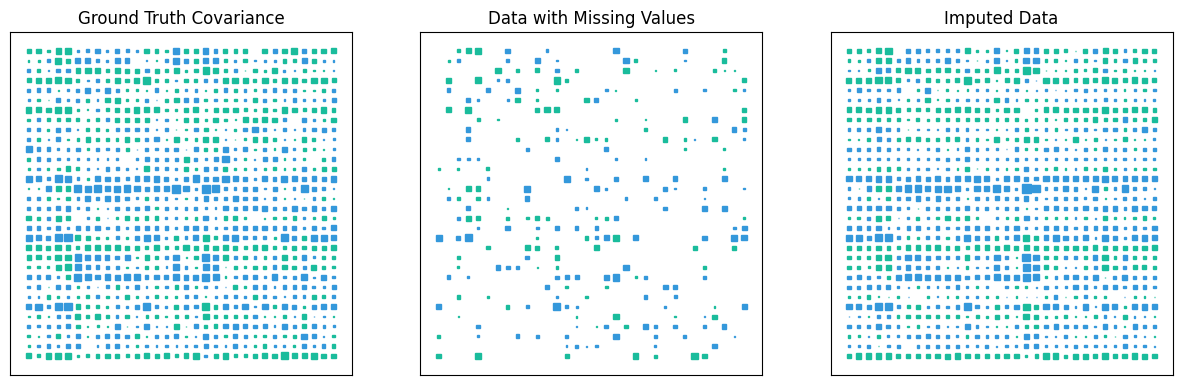

In [7]:
np.random.seed(42)
data_dim = 32
sample_size = 32
threshold_missing = 0.75

_ = gen_imputer_data(data_dim, sample_size, threshold_missing, plot=True)

In [8]:
threhold_delta = 0.01
threholds = np.arange(0.01, 0.99, threhold_delta)

mse_list = []

for threshold_missing in threholds:
    np.random.seed(42)
    gt_data, data, imputed_data = gen_imputer_data(
        data_dim, sample_size, threshold_missing, plot=False
    )
    mse = np.mean((gt_data - imputed_data) ** 2)
    mse_list.append(mse)

fig = go.Figure(
    go.Scatter(x=threholds, y=mse_list, mode="lines", name="MSE", line=dict(width=3))
)
fig.update_layout(
    title="MSE vs. Threshold of Missing Values",
    xaxis_title="Threshold of Missing Values",
    yaxis_title="MSE",
)
fig.show()